In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

2023-04-23 14:49:39.270191: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 14:49:39.321558: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-23 14:49:39.322207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 14:49:40.183437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df_t = pd.read_csv('temperature.csv',index_col=0)
df_h = pd.read_csv('humidity.csv',index_col=0)
df_p = pd.read_csv('pressure.csv',index_col=0)
df_w = pd.read_csv('wind_speed.csv',index_col=0)
df_h.columns

Index(['Vancouver', 'Portland', 'San Francisco', 'Seattle', 'Los Angeles',
       'San Diego', 'Las Vegas', 'Phoenix', 'Albuquerque', 'Denver',
       'San Antonio', 'Dallas', 'Houston', 'Kansas City', 'Minneapolis',
       'Saint Louis', 'Chicago', 'Nashville', 'Indianapolis', 'Atlanta',
       'Detroit', 'Jacksonville', 'Charlotte', 'Miami', 'Pittsburgh',
       'Toronto', 'Philadelphia', 'New York', 'Montreal', 'Boston',
       'Beersheba', 'Tel Aviv District', 'Eilat', 'Haifa', 'Nahariyya',
       'Jerusalem'],
      dtype='object')

In [3]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [4]:
city = 'San Diego'
tempog = df_t[city]
temp = df_t[city].rename("temperature").to_frame(name='temperature')
humid = df_h[city].rename("humidity").to_frame(name='humidity')
press = df_p[city].rename("presure").to_frame(name='presure')
wind = df_w[city].rename("wind").to_frame(name='wind')


features = pd.concat([temp, press, humid, wind], axis=1)
# features.index = time
features = features.dropna()
features

featuresog = features
featuresog

,temperature,presure,humidity,wind
datetime,,,,
2012-10-01 13:00:00,291.530000,1013.0,82.0,0.0
2012-10-01 14:00:00,291.533501,1013.0,81.0,0.0
2012-10-01 15:00:00,291.543355,1013.0,81.0,0.0
2012-10-01 16:00:00,291.553209,1013.0,81.0,0.0
2012-10-01 17:00:00,291.563063,1013.0,80.0,0.0
...,...,...,...,...
2017-11-29 20:00:00,292.150000,1017.0,72.0,2.0
2017-11-29 21:00:00,292.740000,1017.0,72.0,1.0
2017-11-29 22:00:00,292.580000,1016.0,68.0,2.0


In [5]:
training_size = int ( 0.8 * features.shape[0])  

dataset=features.values
data_mean = dataset[:training_size].mean(axis=0)
data_std = dataset[:training_size].std(axis=0)
dataset = (dataset-data_mean)/data_std

dataset.shape

(44899, 4)

In [6]:
features = normalize(features.values)
features = pd.DataFrame(features)
features

,0,1,2,3
0,0.222888,-0.528665,0.731908,-1.181374
1,0.223482,-0.528665,0.680392,-1.181374
2,0.225155,-0.528665,0.680392,-1.181374
3,0.226829,-0.528665,0.680392,-1.181374
4,0.228502,-0.528665,0.628876,-1.181374
...,...,...,...,...
44894,0.328173,-0.061829,0.216750,0.162904
44895,0.428364,-0.061829,0.216750,-0.509235
44896,0.401194,-0.178538,0.010687,0.162904
44897,0.406288,-0.178538,-0.246892,0.162904


In [7]:
past_history = 48
future_target = 24
STEP = 1

In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [9]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 training_size, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             training_size, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(35871, 48, 4)
(35871, 24)


In [10]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (48, 4)

 Target temperature to predict : (24,)


In [11]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() # .repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat() # .repeat()

2023-04-23 14:49:42.113457: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [13]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='tanh'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

2023-04-23 14:49:42.573400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:49:42.575049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:49:42.576388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10


2023-04-23 14:49:42.881000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [35871,24]
	 [[{{node Placeholder/_1}}]]
2023-04-23 14:49:42.881399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [35871,48,4]
	 [[{{node Placeholder/_0}}]]
2023-04-23 14:49:43.135834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

199/200 [============================>.] - ETA: 0s - loss: 0.4245

2023-04-23 14:49:53.312231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [8908,24]
	 [[{{node Placeholder/_1}}]]
2023-04-23 14:49:53.552706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:49:53.554317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor

200/200 [==============================] - 12s 42ms/step - loss: 0.4233 - val_loss: 0.3652
Epoch 2/10
200/200 [==============================] - 8s 38ms/step - loss: 0.2334 - val_loss: 0.2710
Epoch 3/10
200/200 [==============================] - 8s 39ms/step - loss: 0.2006 - val_loss: 0.2501
Epoch 4/10
200/200 [==============================] - 8s 39ms/step - loss: 0.1821 - val_loss: 0.2458
Epoch 5/10
200/200 [==============================] - 8s 38ms/step - loss: 0.1885 - val_loss: 0.2497
Epoch 6/10
200/200 [==============================] - 8s 38ms/step - loss: 0.1724 - val_loss: 0.2605
Epoch 7/10
200/200 [==============================] - 8s 39ms/step - loss: 0.1685 - val_loss: 0.2554
Epoch 8/10
200/200 [==============================] - 8s 38ms/step - loss: 0.1617 - val_loss: 0.2700
Epoch 9/10
200/200 [==============================] - 8s 39ms/step - loss: 0.1640 - val_loss: 0.2604
Epoch 10/10
200/200 [==============================] - 8s 38ms/step - loss: 0.1629 - val_loss: 0.2701

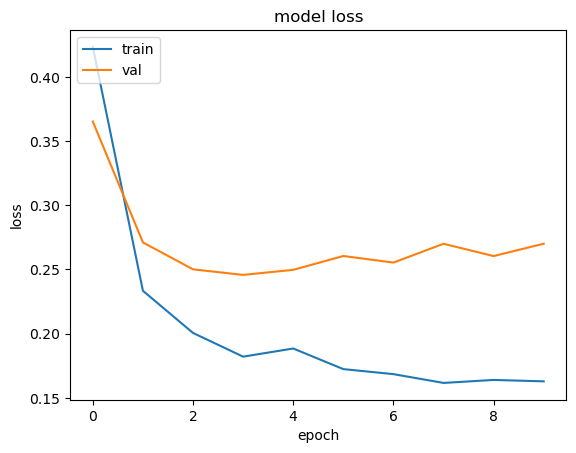

In [15]:
# Plot training loss and validation
plt.plot(multi_step_history.history['loss'])
plt.plot(multi_step_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
def create_time_steps(length):
  return list(range(-length, 0))

2023-04-23 14:51:04.045974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [8908,24]
	 [[{{node Placeholder/_1}}]]
2023-04-23 14:51:04.348095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:51:04.349759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor

8/8 [==============================] - 1s 6ms/step


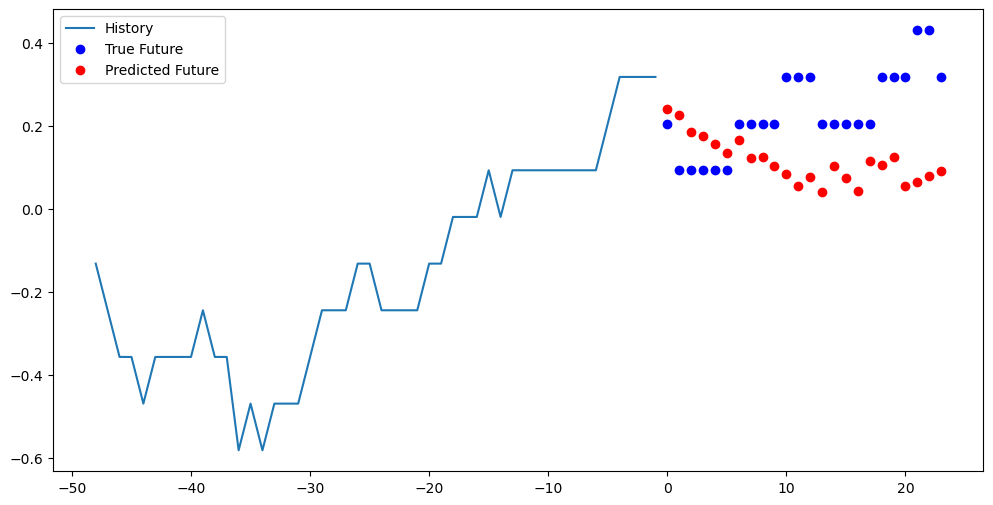

8/8 [==============================] - 0s 6ms/step


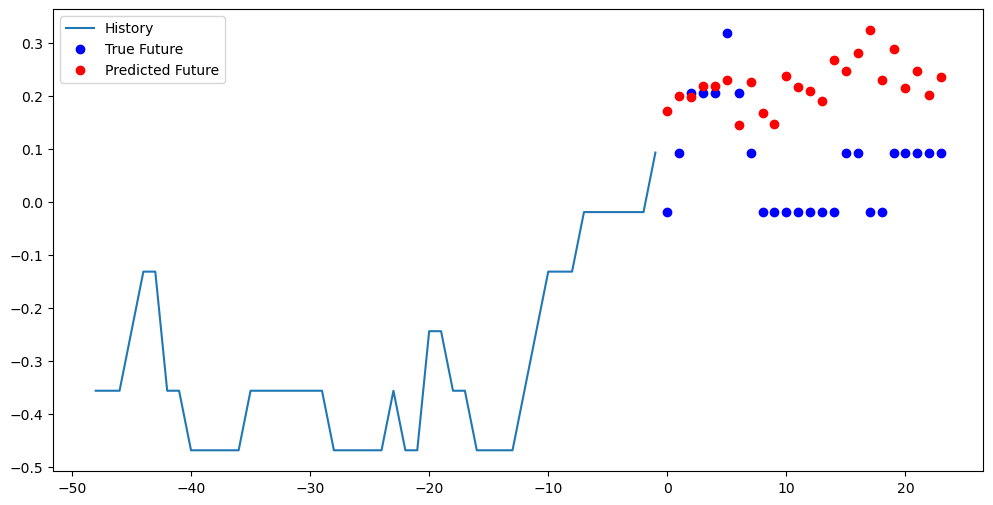

8/8 [==============================] - 0s 6ms/step


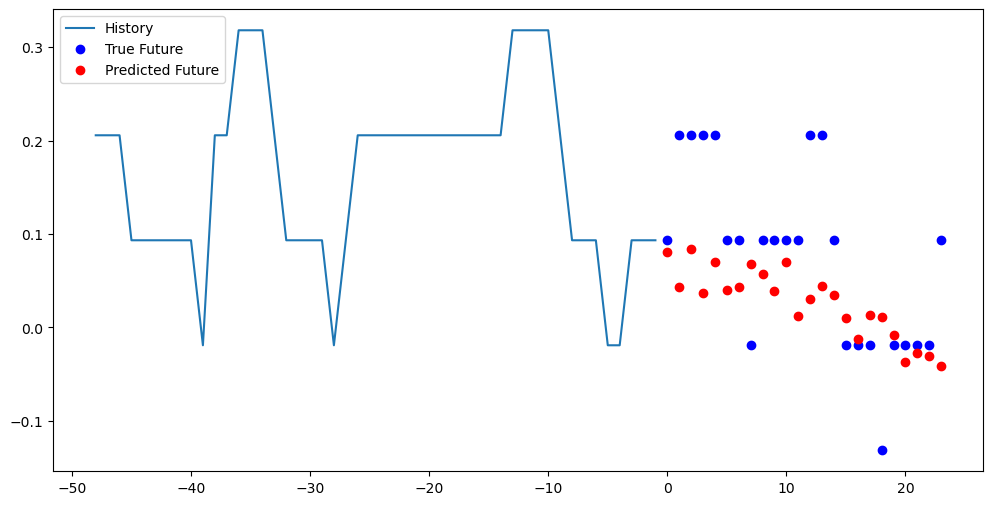

8/8 [==============================] - 0s 6ms/step


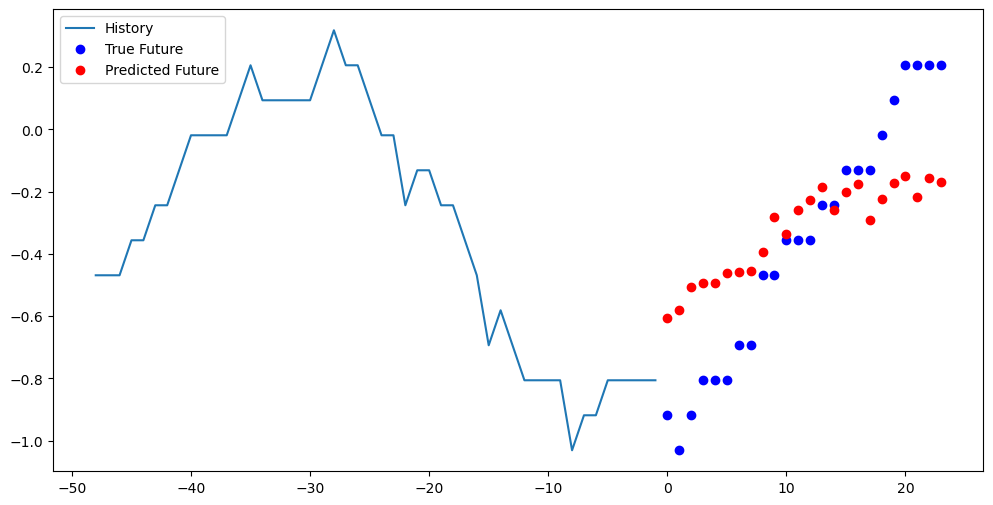

8/8 [==============================] - 0s 6ms/step


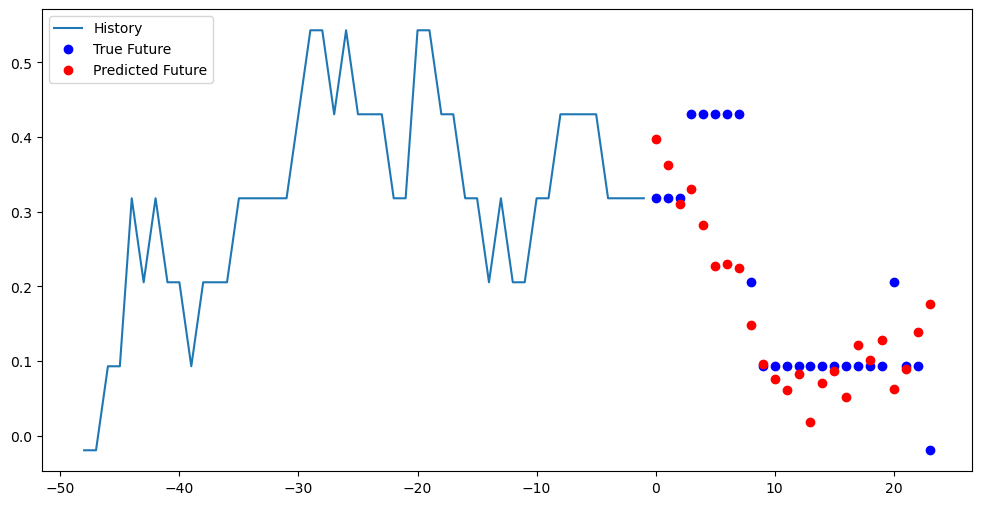

In [17]:
for x, y in val_data_multi.take(5):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [18]:
multi_step_model.save("w_model")

2023-04-23 14:51:06.589700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:51:06.591341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:51:06.592704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-04-23 14:51:08.075763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:51:08.077377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:51:08.078745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-04-23 14:51:09.088215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'lstm_input' with dtype float and shape [?,48,4]
	 [[{{node lstm_input}}]]
2023-04-23 14:51:09.113819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,48,4]
	 [[{{node inputs}}]]
2023-04-23 14:51:09.129032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,48,4]
	 [[{{node inputs}}]]
2023-

2023-04-23 14:51:10.828808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-23 14:51:10.830383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-23 14:51:10.831752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-04-23 14:51:12.227300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_lstm_input' with dtype float and shape [?,48,4]
	 [[{{node serving_default_lstm_input}}]]


INFO:tensorflow:Assets written to: w_model/assets


INFO:tensorflow:Assets written to: w_model/assets
